# 3W - Strategy Thinking project

## <a id="TableOfContents"></a>Table Of Contents ##
* [Conclusion](#Conclusion)

In [108]:
# IMPORTS AND CONFIGURATIONS

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

import glob
import os
import time

from sklearn.dummy import DummyClassifier

import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

import pickle
from sklearn.pipeline import make_pipeline, Pipeline

## Data Preparation

Preprocessing a dataset through data characterisation involves summarising the features and characteristics present in the data using statistical measures and visualisations techniques such as bar charts and scatter plots. After this stage, it should be possible to identify biases, patterns, trends, and any missing or irrelevant data in the data set that may need to be addressed.

This dataset is composed by instances of eight types of undesirable events characterized by eight process variables from three different sources: real instances, simulated instances and hand-drawn instances. All real instances were taken from the plant information system that is used to monitor the industrial processes at an operational unit in Brazilian state of Espírito Santo. The simulated instances were all generated using OLGA ([Schlumberger](https://www.software.slb.com/products/olga)), a dynamic multiphase flow simulator that is widely used by oil companies worldwide (Andreolli, 2016). Finally, the hand-drawn instances were generated by a specific tool developed by Petrobras researchers for this dataset to incorporate undesirable events classfied as rare. 
 
### Data Characterisation
The data consists of over 50 million observations, with 13 columns of data for each observation. The first column, `label`, indicates the event type for each observation. The second column, `well`, contains the name of the well the observation was taken from. Hand-drawn and simulated instances have fixed names for in this column, while real instances have names masked with incremental id. The third column, `id`, is an identifier for the observation and it is incremental for hand-drawn and simulated instances, while each real instance has an id generated from its first timestamp. The columns representing the process variables are:

* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG) - installed on Christmas Tree;
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT) - installed on Christmas Tree;
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP) - located on platform;
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;

The pressure features are measured in Pascal (Pa), the volumetric flow rate features are measured in standard cubic meters per second (SCM/s), and the temperature features are measured in degrees Celsius (°C).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type) - target variable;
* **well**: well name. Hand-drawn and simulated instances have fixed names (respectively, `drawn` and `simulated`. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp;
* **class**: Although it can be used to identify periods of normal operation, fault transients, and faulty steady states, which can help with diagnosis and maintenance, it is a category which results from label, which is our target here

The labels are:
* 0 - Normal Operation = `Normal`
* 1 - Abrupt Increase of BSW = `AbrIncrBSW`
* 2 - Spurious Closure of DHSV = `SpurClosDHSW`
* 3 - Severe Slugging = `SevSlug`
* 4 - Flow Instability = `FlowInst`
* 5 - Rapid Productivity Loss = `RProdLoss`
* 6 - Quick Restriction in PCK	= `QuiRestrPCK`
* 7 - Scaling in PCK = `ScalingPCK`
* 8 - Hydrate in Production Line = `HydrProdLine`

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/petrobras/3W/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/petrobras/3W/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In order to maintain the realistic aspects of the data, the dataset was extracted without preprocessing, including the presence of `NaN` values, frozen variables due to sensor or communication issues, instances with varying sizes, and outliers (R.E.V. Vargas, et al. 2019). 

From all 50,822,124 entries, 3,086,851 are duplicated, that is, approximately 6.07% of total. These duplicated rows may be related to frozen variables from real instances, as simulated and hand-drawn instances are naturally free of such problems. Although no missing values were found for columns `label`, `well`, and `id`, other features presented null or absent values. Notably, the column `T-JUS-CKGL` turned out to be completely empty.

In [2]:
%%time
df = pd.read_csv('3Wdataset_real.csv', index_col=None, parse_dates=['timestamp'])

# only using real, since simulated and drawn doesnt have records for QGL and P-JUS-CKGL
# df_real.info()

# df_drawn = pd.read_csv('3Wdataset_drawn.csv', index_col=None)
# # df_drawn.info()

# df_sim1 = pd.read_csv('3Wdataset_simulated_1of2.csv', index_col=None)
# # df_sim1.info()

# df_sim2 = pd.read_csv('3Wdataset_simulated_2of2.csv', index_col=None)
# # df_sim2.info()

# df = pd.concat([
#     df_real,
#     df_sim1,
#     df_sim2,
#     df_drawn
# ])

# df = df.drop('source', axis=1)

# dismissing temporary DFs to release memory
# del df_sim1
# del df_sim2
# del df_real
# del df_drawn

df.shape

CPU times: user 18.7 s, sys: 4.58 s, total: 23.3 s
Wall time: 23.8 s


(13952911, 14)

### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13952911 entries, 0 to 13952910
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   id          int64         
 4   P-PDG       float64       
 5   P-TPT       float64       
 6   T-TPT       float64       
 7   P-MON-CKP   float64       
 8   T-JUS-CKP   float64       
 9   P-JUS-CKGL  float64       
 10  T-JUS-CKGL  float64       
 11  QGL         float64       
 12  class       float64       
 13  source      object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.5+ GB


In [4]:
df.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,source
0,2017-06-25 22:01:27,0,WELL-00002,20170625220127,0.0,8698015.0,117.6015,2142158.0,75.63453,2310426.0,NaN,0.0,0.0,real
1,2017-06-25 22:01:28,0,WELL-00002,20170625220127,0.0,8698015.0,117.6014,2172395.0,75.65491,2310427.0,NaN,0.0,0.0,real
2,2017-06-25 22:01:29,0,WELL-00002,20170625220127,0.0,8698015.0,117.6013,2202631.0,75.67529,2310427.0,NaN,0.0,0.0,real
3,2017-06-25 22:01:30,0,WELL-00002,20170625220127,0.0,8698015.0,117.6012,2180472.0,75.69567,2310427.0,NaN,0.0,0.0,real
4,2017-06-25 22:01:31,0,WELL-00002,20170625220127,0.0,8698015.0,117.6011,2158313.0,75.71606,2310428.0,NaN,0.0,0.0,real


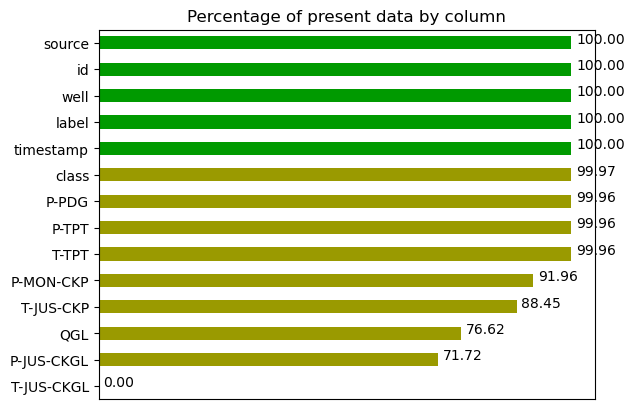

In [5]:
present_pct = df.count().sort_values() / df.shape[0] * 100

all_present = present_pct == 100
colors = all_present.map({True: '#009a00', False: '#9a9a00'})

fig, ax = plt.subplots()

ax = present_pct.plot.barh(color=colors)
ax.set_title('Percentage of present data by column')
ax.grid(False)
ax.set_facecolor('white')
ax.set_xticks([])

for i, v in enumerate(present_pct):
    ax.text(v + 1, i, f'{v:.2f}', color='black')

plt.show()

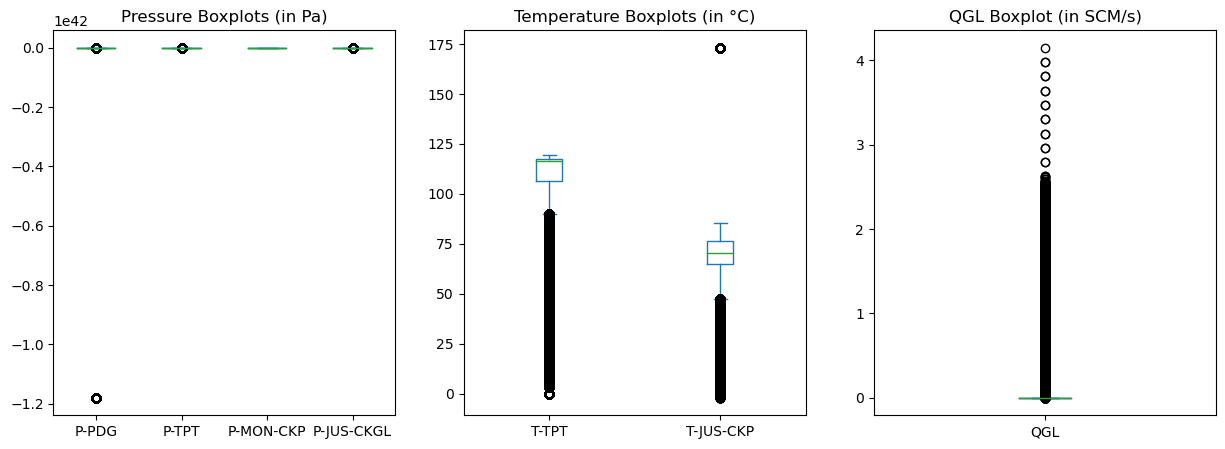

In [6]:
pressure_cols = ['P-PDG', 'P-TPT', 'P-MON-CKP', 'P-JUS-CKGL']
temp_cols = ['T-TPT', 'T-JUS-CKP']

# create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df[pressure_cols].plot(kind='box', ax=axs[0])
axs[0].set_title('Pressure Boxplots (in Pa)')

df[temp_cols].plot(kind='box', ax=axs[1])
axs[1].set_title('Temperature Boxplots (in °C)')

# create boxplots for QGL
df[['QGL']].plot(kind='box', ax=axs[2])
axs[2].set_title('QGL Boxplot (in SCM/s)')

plt.show()


### Data Cleaning

In [7]:
# drop rows with missing or null class column
df_clean = df.dropna(subset=[
    'class','P-PDG','P-TPT','T-JUS-CKP','P-MON-CKP','T-TPT','P-MON-CKP','QGL','P-JUS-CKGL'
])

# variables due to sensor or communication issues
# removing class, since it results from label
# removing ID from df

df_clean = df_clean.drop([
#     'timestamp', 
    'class',
    'T-JUS-CKGL', # T-JUS-CKGL is empty
    'id', 
    'source'
], axis=1)

# checking duplicated rows after removing ids
df_clean = df_clean.drop_duplicates()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10003580 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   P-PDG       float64       
 4   P-TPT       float64       
 5   T-TPT       float64       
 6   P-MON-CKP   float64       
 7   T-JUS-CKP   float64       
 8   P-JUS-CKGL  float64       
 9   QGL         float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 839.5+ MB


In [8]:
# Finding missing values
missing = df_clean.isnull()
missing.sum()

total_missing = df_clean.isnull().sum()
percent_missing = total_missing * 100 / len(df_clean)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

# Total of Missing Values
missing_value_df.sum()

percent    0.0
total      0.0
dtype: float64

In [9]:
# removing extreme outliers from P-PDG 
Q1 = df_clean['P-PDG'].quantile(0.25)
Q3 = df_clean['P-PDG'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (3 * IQR)
# upper_bound = Q3 + (3 * IQR)

# df_no_outliers = df_clean[(df_clean['P-PDG'] >= lower_bound) & (df_clean['P-PDG'] <= upper_bound)]
df_no_outliers = df_clean[(df_clean['P-PDG'] >= lower_bound)]


# removing extreme outliers from P-TPT
Q1 = df_no_outliers['P-TPT'].quantile(0.25)
Q3 = df_no_outliers['P-TPT'].quantile(0.75)
IQR = Q3 - Q1

# lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

df_no_outliers = df_no_outliers[(df_no_outliers['P-TPT'] <= upper_bound)]


df_no_outliers.shape

(9780901, 10)

In [10]:
pct_removed = (df_clean.shape[0] - df_no_outliers.shape[0]) / df_clean.shape[0]
print(pct_removed)


0.02225993094472179


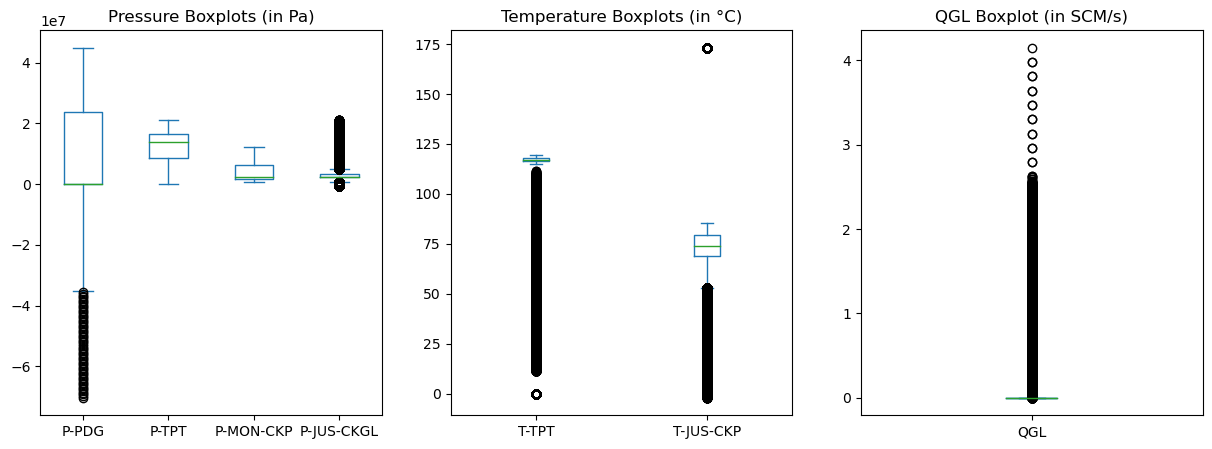

In [11]:
# figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# boxplots for pressure columns
df_no_outliers[pressure_cols].plot(kind='box', ax=axs[0])
axs[0].set_title('Pressure Boxplots (in Pa)')

# boxplots for temperature columns (but T-JUS-CKGL)
df_no_outliers[temp_cols].plot(kind='box', ax=axs[1])
axs[1].set_title('Temperature Boxplots (in °C)')

# create boxplots for QGL
df_no_outliers[['QGL']].plot(kind='box', ax=axs[2])
axs[2].set_title('QGL Boxplot (in SCM/s)')

plt.show()


### Feature Engineering

In [12]:
dt_feat = df_no_outliers

# Change 'label' column to object dtype
dt_feat['label'] = dt_feat['label'].astype('object') 

# Create boolean columns for each label
label_dummies = pd.get_dummies(dt_feat['label'], prefix='label')
dt_feat = pd.concat([dt_feat, label_dummies], axis=1)

# Rename boolean columns
column_names = {
    'label_0': 'Normal',
    'label_1': 'AbrIncrBSW',
    'label_2': 'SpurClosDHSW',
    'label_3': 'SevSlug',
    'label_4': 'FlowInst',
    'label_5': 'RProdLoss',
    'label_6': 'QuiRestrPCK',
    'label_7': 'ScalingPCK',
    'label_8': 'HydrProdLine'
}
dt_feat = dt_feat.rename(columns=column_names)

# Drop the original 'label' column and Normal column, since all other events must be 0
dt_feat = dt_feat.drop(['label','Normal'], axis=1)

dt_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780901 entries, 0 to 13952910
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   timestamp     datetime64[ns]
 1   well          object        
 2   P-PDG         float64       
 3   P-TPT         float64       
 4   T-TPT         float64       
 5   P-MON-CKP     float64       
 6   T-JUS-CKP     float64       
 7   P-JUS-CKGL    float64       
 8   QGL           float64       
 9   AbrIncrBSW    uint8         
 10  SpurClosDHSW  uint8         
 11  SevSlug       uint8         
 12  FlowInst      uint8         
 13  RProdLoss     uint8         
 14  QuiRestrPCK   uint8         
 15  ScalingPCK    uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(7)
memory usage: 811.5+ MB


In [13]:
dt_feat_target = dt_feat.drop([
    'AbrIncrBSW',
    'SpurClosDHSW',
#     'SevSlug',
    'FlowInst',
    'RProdLoss',
    'QuiRestrPCK',
    'ScalingPCK'
#     ,'HydrProdLine'
], axis=1)

dt_feat_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780901 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   well        object        
 2   P-PDG       float64       
 3   P-TPT       float64       
 4   T-TPT       float64       
 5   P-MON-CKP   float64       
 6   T-JUS-CKP   float64       
 7   P-JUS-CKGL  float64       
 8   QGL         float64       
 9   SevSlug     uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(1)
memory usage: 755.6+ MB


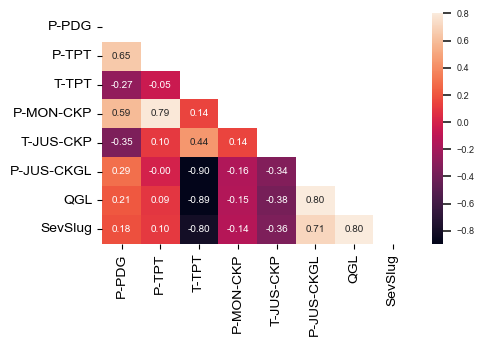

In [14]:
# Computing the correlations
corr = dt_feat_target.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(5, 3))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax, fmt='.2f')
plt.show()

### Train/Test Splitting and Handling Imbalanced Data

In [93]:
# defining features (X) and label (y)
target = 'SevSlug'

X = dt_feat_target.drop([target,'timestamp','well'], axis=1)
y = dt_feat_target[target]

# splitting data into train and test sets
X_train_u, X_test, y_train_u, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_names = {0:'Non Sev Slug', 1:'SEV SLUGGING'}

print(y_train_u.value_counts(normalize=True).rename(index=class_names))

Non Sev Slug    0.94194
SEV SLUGGING    0.05806
Name: SevSlug, dtype: float64


In [95]:
[
    X_train_u.shape, y_train_u.shape, 
    X_test.shape, y_test.shape
]


[(6846630, 7), (6846630,), (2934271, 7), (2934271,)]

In [99]:
# balancing data 
balancing = RandomUnderSampler(random_state=42)
# balancing = SMOTE(random_state=42)
# balancing = SMOTETomek(random_state=42)

X_train, y_train = balancing.fit_resample(X_train_u, y_train_u)

print(y_train_u.value_counts(normalize=True).rename(index=class_names),end='\n\n')
print([X_train.shape, y_train.shape])

Non Sev Slug    0.94194
SEV SLUGGING    0.05806
Name: SevSlug, dtype: float64

[(795026, 7), (795026,)]


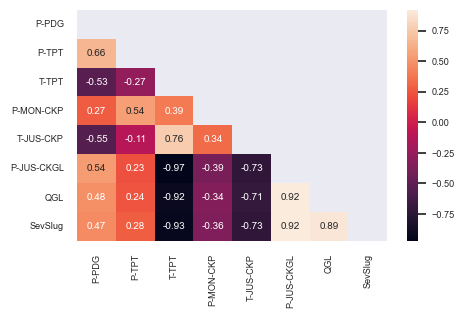

In [100]:
# Computing the correlations using X_train and y_train
train_df = pd.concat([X_train, y_train], axis=1)
corr = train_df.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(5, 3))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax, fmt='.2f')
plt.show()

del train_df

### Data Scaling

In [21]:
def plot_data_scaling(X_train_transformed, scaler_name):
    df_scaled = pd.DataFrame(X_train_transformed, columns=X_train.columns)
    df_scaled.plot(kind='box', figsize=(8, 5))

    plt.title(f'Boxplot of Features After Scaling ({scaler_name})')
    plt.xlabel('Features')
    plt.ylabel('Value')
    
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.show()

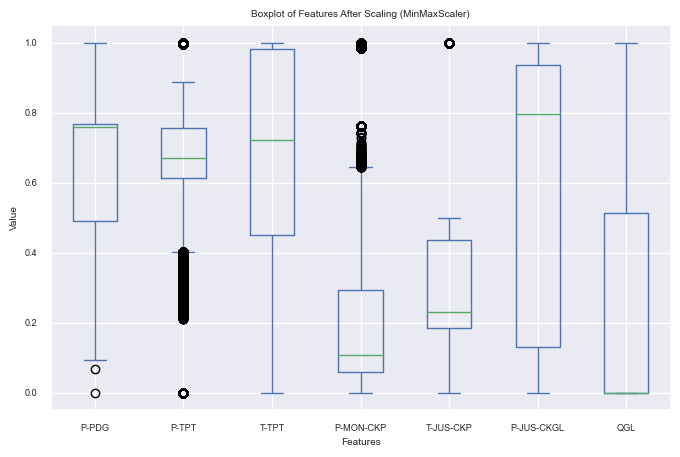

In [22]:
minmax_scaler_pipeline = make_pipeline(MinMaxScaler())
minmax_scaler_pipeline.fit(X_train)

X_train_transformed = minmax_scaler_pipeline.transform(X_train)

plot_data_scaling(X_train_transformed, 'MinMaxScaler')

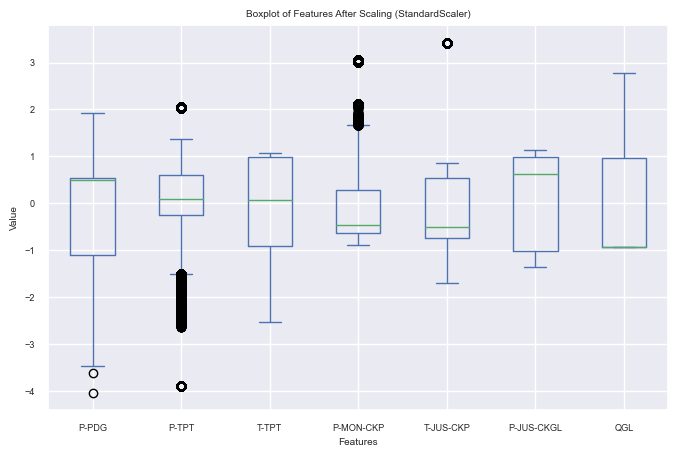

In [23]:
std_scaler_pipeline = make_pipeline(StandardScaler())
std_scaler_pipeline.fit(X_train)

X_train_transformed = std_scaler_pipeline.transform(X_train)

plot_data_scaling(X_train_transformed, 'StandardScaler')

## Dimensionality Reduction

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def plot_cumul_sum(variance_captured, title):
    cum_sum_eigenvalues = np.cumsum(variance_captured)

    plt.bar(
        range(0,len(variance_captured)), 
        variance_captured, alpha=0.5, align='center', 
        label='Individual explained variance'
    )

    plt.step(
        range(0,len(cum_sum_eigenvalues)), 
        cum_sum_eigenvalues, where='mid',
        label='Cumulative explained variance'
    )

    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    sum_vc = sum(variance_captured)
    plt.title(f'Variance Captured ({title}) = {sum_vc}')
    plt.show()
    

def plot_3d_chart(X_train_reduced, y_train):
    Xax, Yax, Zax = X_train_reduced[:,0], X_train_reduced[:,1], X_train_reduced[:,2]

    cdict = {0:'green',1:'red'}
    labl = {0:'Non SevSlug',1:'SevSlug'}
    marker = {0:'*',1:'o'}
    alpha = {0:.3, 1:.5}

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')

    fig.patch.set_facecolor('white')

    for l in np.unique(y_train):
        ix=np.where(y_train==l)
        ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
               label=labl[l], marker=marker[l], alpha=alpha[l])

    # for loop ends
    ax.set_xlabel("1st Prin. Component", fontsize=14)
    ax.set_ylabel("2nd Prin. Component", fontsize=14)
    ax.set_zlabel("3rd Prin. Component", fontsize=14)

    ax.legend()
    plt.show()

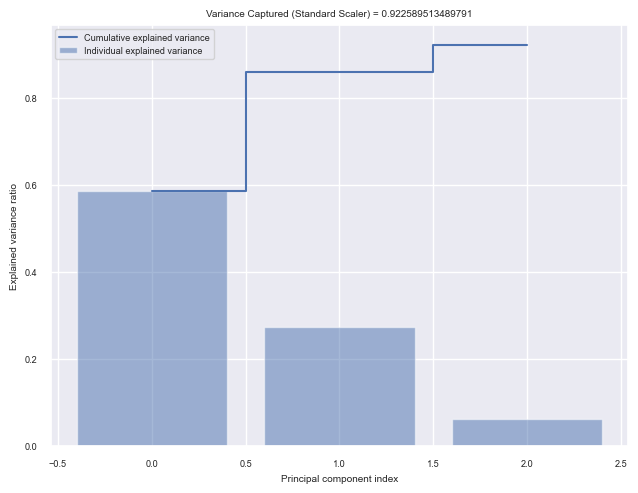

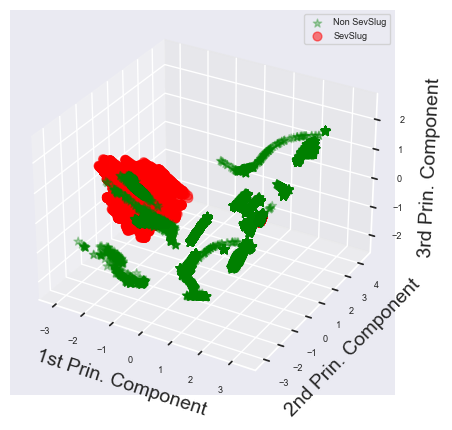

In [27]:
preproc_pipeline = make_pipeline(std_scaler_pipeline, PCA(n_components=3))
preproc_pipeline.fit(X_train)
X_train_reduced = preproc_pipeline.transform(X_train)
plot_cumul_sum(preproc_pipeline.named_steps['pca'].explained_variance_ratio_, 'Standard Scaler')
plot_3d_chart(X_train_reduced, y_train)

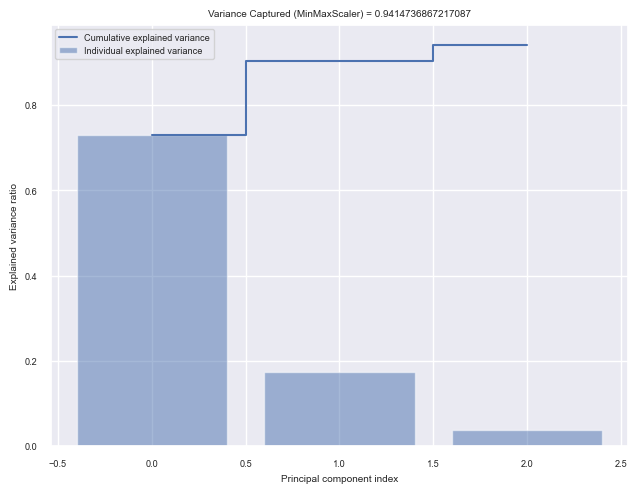

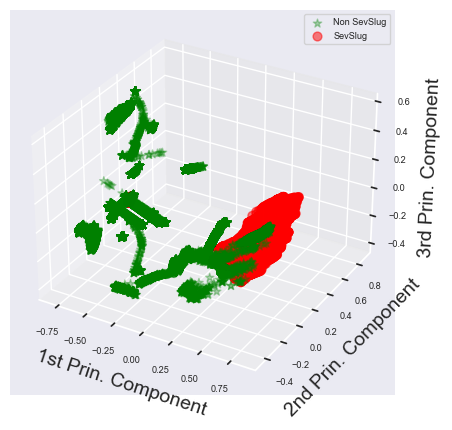

In [28]:
preproc_pipeline = make_pipeline(minmax_scaler_pipeline, PCA(n_components=3))
preproc_pipeline.fit(X_train)
X_train_reduced = preproc_pipeline.transform(X_train)
plot_cumul_sum(preproc_pipeline.named_steps['pca'].explained_variance_ratio_, 'MinMaxScaler')
plot_3d_chart(X_train_reduced, y_train)

## Machine Learning

In [29]:
# DummyClassifier
dummy_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3), DummyClassifier())
dummy_pipeline.fit(X_train, y_train)

# confirming if score for Dummy classifier results from a balanced dataset
score = dummy_pipeline.score(X_train, y_train)
y_predicted = dummy_pipeline.predict(X_test)
baseline = metrics.accuracy_score(y_test, y_predicted)

print("Score: ", score)
print("Accuracy: ",baseline)

Score:  0.5
Accuracy:  0.9417780429960286


### Linear SVC
#### Running pipeline from file

In [78]:
with open(os.path.join('pickle', 'linear_svc_pipeline.pkl'), 'rb') as f:
    linear_svc_pipeline = pickle.load(f)
    
y_predicted_lin_clf = linear_svc_pipeline.predict(X_test)    
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_lin_clf))

Accuracy:  0.9800577383615896


#### Hyperparameter optimisation and Model training

In [74]:
%%time
# TRAINING THE MODEL

from sklearn.svm import LinearSVC

param_grid = {
    'dimred__n_components': [3, 4], 
    'linearsvc__C': [1e-2, 1e-1, 1, 10, 100],
    'linearsvc__penalty':['l1', 'l2'],
    'linearsvc__dual': [False, True],
    'linearsvc__class_weight': ['balanced',None]
}

linear_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dimred', PCA()), 
    ('linearsvc', LinearSVC())
])

grid_search_lsvc = GridSearchCV(
    linear_svc_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_lsvc.fit(X_train, y_train)

os.system('say "the Hyperparameters for LinearSVC were successfully found."')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/victorf/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_

CPU times: user 7.14 s, sys: 1.58 s, total: 8.72 s
Wall time: 36min 5s


0

In [75]:
print("Score: ", grid_search_lsvc.best_score_)

Score:  0.9745744165938113


In [76]:
linear_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dimred', PCA(
        n_components=grid_search_lsvc.best_params_['dimred__n_components']
    )),
    ('linearsvc', LinearSVC(
        dual=grid_search_lsvc.best_params_['linearsvc__dual'],
        C=grid_search_lsvc.best_params_['linearsvc__C'],
        penalty=grid_search_lsvc.best_params_['linearsvc__penalty'],
        class_weight=grid_search_lsvc.best_params_['linearsvc__class_weight']
    ))
])

linear_svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('dimred', PCA(n_components=3)),
                ('linearsvc',
                 LinearSVC(C=0.01, class_weight='balanced', dual=False,
                           penalty='l1'))])

In [77]:
# saving model
with open(os.path.join('pickle', 'linear_svc_pipeline.pkl'), 'wb') as f:
    pickle.dump(linear_svc_pipeline, f)

### SGD Classifier
#### Running pipeline from file

In [32]:
with open(os.path.join('pickle', 'sgd_pipeline.pkl'), 'rb') as f:
    sgd_pipeline = pickle.load(f)
    
y_predicted_sgd = sgd_pipeline.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_sgd))

Accuracy:  0.9800553527605324


#### Hyperparameter optimisation and Model training

In [373]:
%%time

from sklearn.linear_model import SGDClassifier

param_grid = {
    'dimred__n_components': [3, 4], 
    'sgdclassifier__max_iter': [10, 100, 1000],
    'sgdclassifier__loss': ['hinge','log_loss'],
    'sgdclassifier__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],    
    'sgdclassifier__class_weight': ['balanced']
}

sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dimred', PCA()), 
    ('sgdclassifier', SGDClassifier())
])

grid_search_sgd = GridSearchCV(
    sgd_pipeline,
    param_grid=param_grid,
    n_jobs=1,
    scoring='accuracy',
    verbose=1
)

grid_search_sgd.fit(X_train, y_train)

os.system('say "the Hyperparameters for SGDClassifer were successfully found."')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 27min 5s, sys: 2min 58s, total: 30min 3s
Wall time: 9min 13s


0

In [374]:
print("Score: ", grid_search_sgd.best_score_)

Score:  0.9747907616595125


In [376]:
sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dimred', PCA(
        n_components=grid_search_lsvc.best_params_['dimred__n_components']
    )),
    ('sgdclassifier', SGDClassifier(
        max_iter=grid_search_sgd.best_params_['sgdclassifier__max_iter'], 
        loss=grid_search_sgd.best_params_['sgdclassifier__loss'],
        alpha=grid_search_sgd.best_params_['sgdclassifier__alpha'],
        class_weight=grid_search_sgd.best_params_['sgdclassifier__class_weight']
    ))
])

sgd_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('dimred', PCA(n_components=3)),
                ('sgdclassifier',
                 SGDClassifier(alpha=1e-06, class_weight='balanced',
                               max_iter=10))])

In [377]:
# saving SGDClassifier model
with open(os.path.join('pickle', 'sgd_pipeline.pkl'), 'wb') as f:
    pickle.dump(sgd_pipeline, f)

### k-Nearest Neighbours
#### Running pipeline from file

In [33]:
%%time
with open(os.path.join('pickle', 'knn_pipeline.pkl'), 'rb') as f:    
    knn_pipeline = pickle.load(f)
    
y_predicted_knn = knn_pipeline.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_knn))

Accuracy:  0.9914281946009759
CPU times: user 1min 20s, sys: 979 ms, total: 1min 21s
Wall time: 1min 21s


#### Hyperparameter optimisation and Model training

In [398]:
%%time

from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('dimred', PCA()), 
    ('kneighborsclassifier', KNeighborsClassifier())
])

param_grid = {
    'dimred__n_components': [3, 4], 
    'kneighborsclassifier__n_neighbors': range(3, 102, 3),
}

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_knn.fit(X_train, y_train)

os.system('say "the Hyperparameters for KNeighborsClassifier were successfully found."')

Fitting 5 folds for each of 66 candidates, totalling 330 fits
CPU times: user 6.33 s, sys: 1.47 s, total: 7.8 s
Wall time: 13min 43s


0

In [399]:
print("Score: ", grid_search_knn.best_score_)

Score:  0.9962240226295519


In [400]:
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('dimred', PCA(
        n_components=grid_search_lsvc.best_params_['dimred__n_components']
    )),
    ('kneighborsclassifier', KNeighborsClassifier(
        n_neighbors=grid_search_knn.best_params_['kneighborsclassifier__n_neighbors']
    ))
])


knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('dimred', PCA(n_components=3)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [401]:
with open(os.path.join('pickle', 'knn_pipeline.pkl'), 'wb') as f:     
    pickle.dump(knn_pipeline, f)

### Artificial Neural Networks
#### Running pipeline from file

In [35]:
# importing necessary modules, KerasClassifier wrapper, Sequential and Dense layers from Keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense


# defining function to create a Keras classifier - this must be defined before loading pickle file
def build_clf(num_units=10):
    # initialize Sequential model and adding layers to it
    ann_clf = tf.keras.models.Sequential()
    ann_clf.add(tf.keras.layers.Dense(units=num_units, activation='relu'))
    ann_clf.add(tf.keras.layers.Dense(units=num_units, activation='relu'))
    ann_clf.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    # compiling model with chosen optimizer, loss function, and evaluation metrics
    ann_clf.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return ann_clf

In [68]:
%%time
with open(os.path.join('pickle', 'ann_pipeline.pkl'), 'rb') as f: 
    ann_pipeline = pickle.load(f)
    
y_predicted_ann = ann_pipeline.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_ann))

91696/91696 [==============================] - 58s 636us/step
Accuracy:  0.9844455403062634
CPU times: user 1min 27s, sys: 6.72 s, total: 1min 34s
Wall time: 1min 20s


#### Hyperparameter optimisation and Model training

In [63]:
%%time

param_grid = {
    'dimred__n_components': [3, 4, 5], 
    'ann_model__batch_size': [16, 32, 64, 128, 256],
    'ann_model__nb_epoch': [5, 8, 13, 21],
    'ann_model__num_units': [5, 8, 13, 21]
}

# creating an instance of the KerasClassifier using the defined function as the build function
ann_model = KerasClassifier(build_fn=build_clf, verbose=0)

ann_pipeline = Pipeline([
    ('scaler',MinMaxScaler()), 
    ('dimred', PCA()), 
    ('ann_model',ann_model)
])

grid_search_ann = GridSearchCV(
    ann_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=0
)

grid_search_ann.fit(X_train, y_train)


os.system('say "the Hyperparameters for Neural Networks were successfully found."')

2023-05-01 10:48:17.088719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:48:17.088791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:48:17.092274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

4969/4969 [==============================] - 10s 2ms/step


2023-05-01 10:51:42.707082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:51:58.154579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3568/4969 [====================>.........] - ETA: 2s

2023-05-01 11:02:38.814626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 10s 2ms/step


2023-05-01 11:02:44.750285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1716/4969 [=========>....................] - ETA: 6s

2023-05-01 11:02:52.886923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2176/4969 [============>.................] - ETA: 5s

2023-05-01 11:02:53.878951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4811/4969 [============================>.] - ETA: 0s

2023-05-01 11:02:58.913937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 589/4969 [==>...........................] - ETA: 8s

2023-05-01 11:03:07.334658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4158/4969 [========================>.....] - ETA: 1s

2023-05-01 11:03:28.306849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 10s 2ms/step


2023-05-01 11:03:40.188964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 11:03:42.355249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 10s 2ms/step


2023-05-01 11:03:55.553942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 11:04:04.345629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1068/4969 [=====>........................] - ETA: 7s

2023-05-01 11:04:19.057490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 10s 2ms/step


2023-05-01 11:05:04.987158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 407/4969 [=>............................] - ETA: 9s

2023-05-01 11:05:20.150866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 12s 2ms/step


4969/4969 [==============================] - 9s 2ms/step


2023-05-01 11:39:56.969290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 9s 2ms/step


2023-05-01 11:40:10.027663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 474/4969 [=>............................] - ETA: 8s

2023-05-01 11:45:43.365209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 13s 3ms/step


2023-05-01 11:45:58.209030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4323/4969 [=========================>....] - ETA: 1s

2023-05-01 11:47:27.047028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1813/4969 [=========>....................] - ETA: 6s

2023-05-01 11:47:43.424968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1782/4969 [=========>....................] - ETA: 4s

2023-05-01 11:48:35.514961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4200/4969 [========================>.....] - ETA: 1s

2023-05-01 11:48:45.949037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 698/4969 [===>..........................] - ETA: 9s

2023-05-01 11:52:43.107159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2404/4969 [=============>................] - ETA: 5s

2023-05-01 11:53:01.584120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 13s 3ms/step


2023-05-01 11:53:17.747973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2686/4969 [===============>..............] - ETA: 4s

2023-05-01 11:53:35.510375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 911/4969 [====>.........................] - ETA: 9s

2023-05-01 11:57:57.903665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  84/4969 [..............................] - ETA: 8ss 

2023-05-01 11:58:14.926408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3118/4969 [=================>............] - ETA: 3s

2023-05-01 12:02:58.922725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 9s 2ms/step


2023-05-01 12:03:11.296783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4969/4969 [==============================] - 9s 2ms/step


4969/4969 [==============================] - 11s 2ms/step


4969/4969 [==============================] - 19s 4ms/step


4969/4969 [==============================] - 12s 2ms/step


4969/4969 [==============================] - 13s 2ms/step


4969/4969 [==============================] - 6s 1ms/step
CPU times: user 1min 50s, sys: 43.6 s, total: 2min 33s
Wall time: 2h 34min 55s


0

In [64]:
print("Score: ", grid_search_ann.best_score_)

Score:  0.9767001124165333


In [65]:
print(grid_search_ann.best_params_)

{'ann_model__batch_size': 16, 'ann_model__nb_epoch': 5, 'ann_model__num_units': 21, 'dimred__n_components': 5}


In [66]:
%%time

ann_model = KerasClassifier(
    build_fn=build_clf,
    num_units=grid_search_ann.best_params_['ann_model__num_units'],
    verbose=0
)

ann_pipeline = Pipeline([
    ('scaler',MinMaxScaler()), 
    ('dimred', PCA(
        n_components=grid_search_ann.best_params_['dimred__n_components']
    )), 
    ('ann_model',ann_model)
])

ann_pipeline.fit(
    X_train, 
    y_train, 
    ann_model__batch_size=grid_search_ann.best_params_['ann_model__batch_size'],
    ann_model__epochs=grid_search_ann.best_params_['ann_model__nb_epoch'], 
    ann_model__verbose=0
)

CPU times: user 4min 11s, sys: 45 s, total: 4min 56s
Wall time: 3min 3s


Pipeline(steps=[('scaler', MinMaxScaler()), ('dimred', PCA(n_components=5)),
                ('ann_model',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7febfec7f070>)])

In [67]:
with open(os.path.join('pickle', 'ann_pipeline.pkl'), 'wb') as f:     
    pickle.dump(grid_search_ann.best_estimator_, f)

INFO:tensorflow:Assets written to: ram://d9e62ace-90cd-487a-a301-122141b2b53a/assets


### Decision Tree
#### Running pipeline from file

In [62]:
%%time
with open(os.path.join('pickle', 'tree_pipeline.pkl'), 'rb') as f:     
    tree_pipeline = pickle.load(f)
    
y_predicted_tree = tree_pipeline.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_tree))

Accuracy:  0.9997593950933639
CPU times: user 313 ms, sys: 228 ms, total: 541 ms
Wall time: 540 ms


#### Hyperparameter optimisation and Model training

In [58]:
%%time

from sklearn.tree import DecisionTreeClassifier

tree_pipeline = Pipeline([
    ('decisiontreeclassifier', DecisionTreeClassifier())
])

param_grid = {
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2']
}

grid_search_tree = GridSearchCV(
    tree_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_tree.fit(X_train, y_train)

os.system('say "the Hyperparameters for DecisionTreeClassifier were successfully found."')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 1.42 s, sys: 413 ms, total: 1.83 s
Wall time: 27.9 s


0

In [59]:
print("Score: ", grid_search_tree.best_score_)

Score:  0.9997849127010063


In [60]:
tree_pipeline = Pipeline([
    ('decisiontreeclassifier', DecisionTreeClassifier(
        min_samples_split=grid_search_tree.best_params_['decisiontreeclassifier__min_samples_split'],
        min_samples_leaf=grid_search_tree.best_params_['decisiontreeclassifier__min_samples_leaf'],
        max_features=grid_search_tree.best_params_['decisiontreeclassifier__max_features']
    ))
])

tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_features='sqrt'))])

In [61]:
with open(os.path.join('pickle', 'tree_pipeline.pkl'), 'wb') as f:        
    pickle.dump(tree_pipeline, f)

### Random Forest
#### Running pipeline from file

In [38]:
%%time
with open(os.path.join('pickle', 'rf_pipeline.pkl'), 'rb') as f:    
    rf_pipeline = pickle.load(f)
    
y_predicted_rf = rf_pipeline.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_rf))

Accuracy:  0.9999219567654113
CPU times: user 13 s, sys: 792 ms, total: 13.7 s
Wall time: 13.9 s


#### Hyperparameter optimisation and Model training

In [393]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier())
])

param_grid = {
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}

grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

os.system('say "the Hyperparameters for RandomForestClassifier were successfully found."')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1min 15s, sys: 1.1 s, total: 1min 17s
Wall time: 4min 37s


0

In [394]:
print("Score: ", grid_search_rf.best_score_)

Score:  0.9999283042283951


In [395]:
%%time
rf_pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(
        class_weight=grid_search_rf.best_params_['randomforestclassifier__class_weight']
    ))
])

rf_pipeline.fit(X_train, y_train)

CPU times: user 1min 17s, sys: 634 ms, total: 1min 17s
Wall time: 1min 17s


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [396]:
with open(os.path.join('pickle', 'rf_pipeline.pkl'), 'wb') as f:        
    pickle.dump(rf_pipeline, f)

## <a id="Conclusion"></a>Conclusion ##

### Classification Report

In [79]:
%%time
# generating a classification report for LinearSVC
cr_linearsvc = metrics.classification_report(y_test, y_predicted_lin_clf, digits=4)

# generating a classification report for SGD
cr_sgd = metrics.classification_report(y_test, y_predicted_sgd, digits=4)

# generating a classification report for kNN
cr_knn = metrics.classification_report(y_test, y_predicted_knn, digits=4)

# # generating a classification report for ANN
y_predicted_ann = y_predicted_ann.flatten()
y_predicted_ann = np.where(y_predicted_ann.round(2) > 0.5, 1, 0)
cr_ann = metrics.classification_report(y_test, y_predicted_ann, digits=4)

# generating a classification report for Decision Tree
cr_tree = metrics.classification_report(y_test, y_predicted_tree, digits=4)

# generating a classification report for Decision Tree
cr_rf = metrics.classification_report(y_test, y_predicted_rf, digits=4)

CPU times: user 21.3 s, sys: 656 ms, total: 22 s
Wall time: 22.2 s


#### Linear SVC

In [80]:
# printing classification report for LinearSVC
print(cr_linearsvc)

              precision    recall  f1-score   support

           0     0.9980    0.9808    0.9893   2763432
           1     0.7568    0.9687    0.8498    170839

    accuracy                         0.9801   2934271
   macro avg     0.8774    0.9747    0.9195   2934271
weighted avg     0.9840    0.9801    0.9812   2934271



#### SGD Classifier

In [41]:
# printing classification report for SGD
print(cr_sgd)

              precision    recall  f1-score   support

           0     0.9980    0.9808    0.9893   2763432
           1     0.7569    0.9685    0.8497    170839

    accuracy                         0.9801   2934271
   macro avg     0.8775    0.9746    0.9195   2934271
weighted avg     0.9840    0.9801    0.9812   2934271



#### k-Neighbours Classifier

In [42]:
# printing classification report for kNN classifier
print(cr_knn)

              precision    recall  f1-score   support

           0     0.9998    0.9911    0.9954   2763432
           1     0.8743    0.9960    0.9312    170839

    accuracy                         0.9914   2934271
   macro avg     0.9370    0.9936    0.9633   2934271
weighted avg     0.9924    0.9914    0.9917   2934271



#### Neural Networks

In [43]:
# printing classification report for ANN
print(cr_ann)

              precision    recall  f1-score   support

           0     0.9980    0.9835    0.9907   2763432
           1     0.7840    0.9680    0.8664    170839

    accuracy                         0.9826   2934271
   macro avg     0.8910    0.9758    0.9285   2934271
weighted avg     0.9855    0.9826    0.9835   2934271



#### Decision Tree

In [44]:
# printing classification report for Decision Tree
print(cr_tree)

              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998   2763432
           1     0.9941    0.9997    0.9969    170839

    accuracy                         0.9996   2934271
   macro avg     0.9971    0.9997    0.9984   2934271
weighted avg     0.9996    0.9996    0.9996   2934271



#### Random Forest

In [45]:
# printing classification report for Random Forest
print(cr_rf)

              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000   2763432
           1     0.9987    1.0000    0.9993    170839

    accuracy                         0.9999   2934271
   macro avg     0.9993    1.0000    0.9996   2934271
weighted avg     0.9999    0.9999    0.9999   2934271



### Confusion Matrix

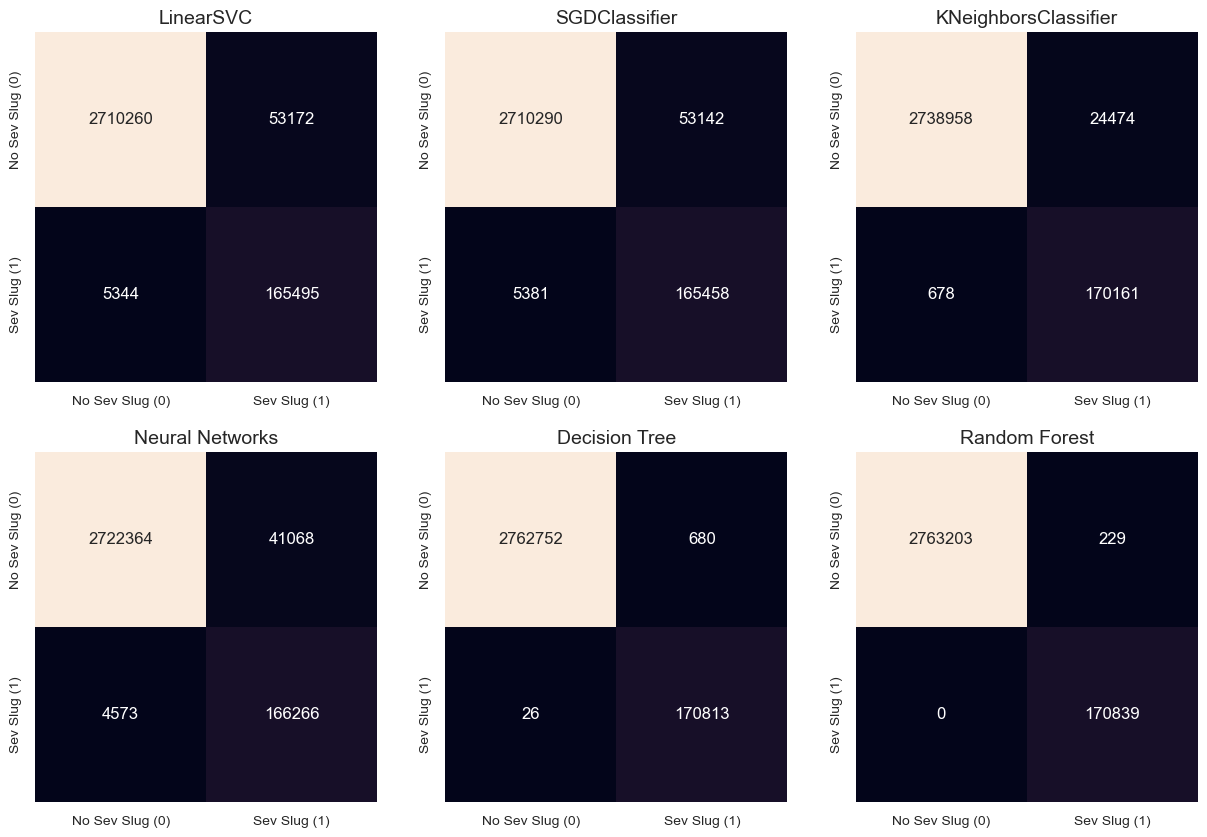

In [81]:
# setting labels valid for all following confusion matrices
cm_labels = ['No Sev Slug (0)', 'Sev Slug (1)']

predictions = [
    y_predicted_lin_clf, 
    y_predicted_sgd, 
    y_predicted_knn, 
    y_predicted_ann,
    y_predicted_tree,
    y_predicted_rf
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# plot each confusion matrix in a subplot
for i, y_predicted in enumerate(predictions):
    row = i // 3
    col = i % 3
    cm = metrics.confusion_matrix(y_test, y_predicted)
    cm_dataframe = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
    
    sns.heatmap(cm_dataframe, annot=True, fmt='d', ax=axs[row, col], cbar=False, annot_kws={"fontsize": 12})
    axs[row, col].tick_params(axis='both', which='major', labelsize=10)
    titles = [
        'LinearSVC','SGDClassifier', 'KNeighborsClassifier',
        'Neural Networks', 
        'Decision Tree', 'Random Forest'
    ]
    axs[row, col].set_title(titles[i], fontsize=14)    
        
plt.show()


### 10-Fold Cross Validation

In [116]:
models = [    
    ('Decision Tree', tree_pipeline),
    ('Random Forest', rf_pipeline), # around 11 min
    ('KNeighborsClassifier', knn_pipeline),    
    ('Neural Networks', ann_pipeline), # around 6 min       
    ('Linear SVC', linear_svc_pipeline),
    ('SGDClassifier', sgd_pipeline)
]

In [119]:
cross_validation_dict = dict()

In [120]:
%%time

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cross_validation_dict[name] = cv_results

    msg = "%s: %f (%f)" % (name, np.nanmean(cv_results), np.nanstd(cv_results))
    print(msg)

Decision Tree: 0.999794 (0.000112)
Random Forest: 0.999947 (0.000022)
KNeighborsClassifier: 0.993417 (0.000229)
2485/2485 [==============================] - 2s 607us/step
Neural Networks: 0.978901 (0.001474)
Linear SVC: 0.974574 (0.000481)
SGDClassifier: 0.974739 (0.000605)
CPU times: user 23min 57s, sys: 2min 7s, total: 26min 5s
Wall time: 20min 6s


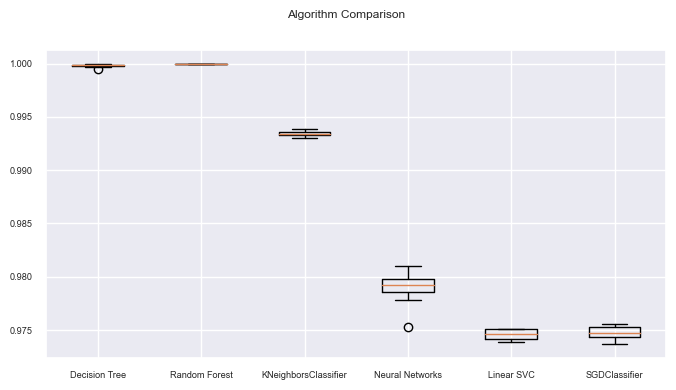

In [123]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cross_validation_dict.values())
ax.set_xticklabels(cross_validation_dict.keys())
fig.set_size_inches(8,4)
plt.show()

<br>[Back to table of contents](#TableOfContents)